In [33]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from google.colab import files



In [34]:
# 2. Upload CSV file
uploaded = files.upload()  # This will open a file picker



Saving merged_data 1.csv to merged_data 1 (1).csv


In [35]:
# 3. Load Data
merged_df = pd.read_csv("merged_data 1.csv")





In [36]:
# ------------------------
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ------------------------
# 2. Create Error Flags
df = merged_df.copy()  # Replace with your dataset variable

# 2. Filter Domestic CSP Students
df = merged_df[
    (merged_df['funding_nation'] == 'Domestic') &
    (merged_df['funding_type'] == "C'wealth Supported")
].copy()



# Total actually paid
df['total_paid'] = df['CSP_gov_payment'] + df['max_student_contrib_2024']
df['expected_fee'] = df['commonwealth_contrib_2024'] + df['max_student_contrib_2024']

# Flag B: Fee mismatch if total paid differs from expected fee by more than 10%
df['flag_B_fee_mismatch'] = np.where(
    df['expected_fee'] == 0, 0,
    (np.abs(df['total_paid'] - df['expected_fee']) / df['expected_fee'] > 0.10).astype(int)
)




# ------------------------
# 2. FOE error (existing column)
df['foe_error'] = df['foe_error'].astype(int)

# ------------------------
# 3. Final error flag (any of the three)
# Use existing overload column instead of creating a new flag
df['error_flag'] = df[['overload', 'flag_B_fee_mismatch', 'foe_error']].max(axis=1)




In [28]:
df.describe()


,course_id,unit_id,unit_level_code,foe_code,eftsl_2024,overload,max_student_contrib_2024,commonwealth_contrib_2024,max_student_contrib_gf_2024,commonwealth_contrib_gf_2024,foe_error,special_code,CSP_gov_payment,total_paid,expected_fee,flag_B_fee_mismatch,error_flag
count,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.0,10528.0,1.052800e+04,1.052800e+04,10528.000000,10528.000000,10528.000000
mean,3491.787519,223609.379274,2.397036,61352.368731,1.286747,0.091375,10153.879274,11460.115027,7989.092610,13398.610467,0.0,0.0,1.723474e+04,2.738862e+04,21613.994301,0.726064,0.731478
std,765.000239,20438.676711,1.405535,34744.889540,3.911831,0.288156,4848.060789,8135.739140,2950.850351,6459.383006,0.0,0.0,7.628492e+04,7.637821e+04,6141.812475,0.445998,0.443212
min,2823.000000,171298.000000,0.000000,10100.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,2976.000000,212270.000000,1.000000,20113.000000,0.125000,0.000000,8948.000000,1236.000000,7659.000000,7008.000000,0.0,0.0,1.864375e+03,1.123450e+04,17559.000000,0.000000,0.000000
50%,3017.000000,234240.500000,2.000000,80307.000000,0.250000,0.000000,8948.000000,14915.000000,8948.000000,14915.000000,0.0,0.0,3.504000e+03,1.663762e+04,22737.000000,1.000000,1.000000
75%,3876.000000,236896.000000,3.000000,91505.000000,0.875000,0.000000,16323.000000,18292.000000,8948.000000,18292.000000,0.0,0.0,1.084912e+04,2.157900e+04,27240.000000,1.000000,1.000000
max,5132.000000,243990.000000,5.000000,129999.000000,97.000000,1.000000,16323.000000,30395.000000,12781.000000,30395.000000,0.0,0.0,2.948315e+06,2.961035e+06,43115.000000,1.000000,1.000000


Error Flags and Data Observations:
In the dataset, binary flags like flag_B_fee_mismatch and error_flag indicate whether a record has an error or anomaly (1) or not (0). The average value of these flags is around 0.73, meaning that roughly **73% **of the records are flagged as having some form of error. This high rate suggests that many records contain anomalies, which could be due to the complexity of fee and funding data, actual discrepancies in the system, or strict rules designed to catch even small mismatches.

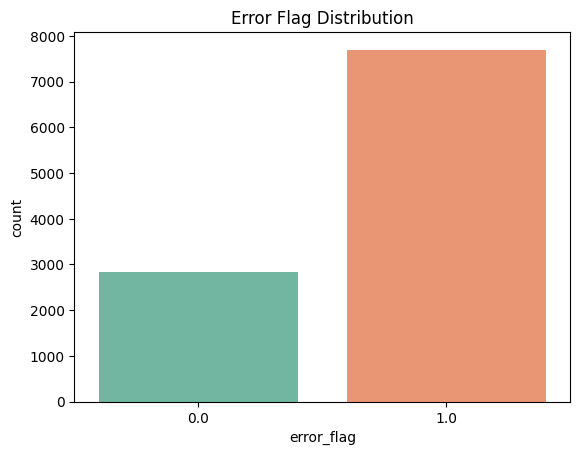

In [74]:
# ------------------------
# 3. Exploratory Data Analysis (EDA)
sns.countplot(x='error_flag', data=df, hue='error_flag', palette='Set2', dodge=False, legend=False)
plt.title("Error Flag Distribution")
plt.show()


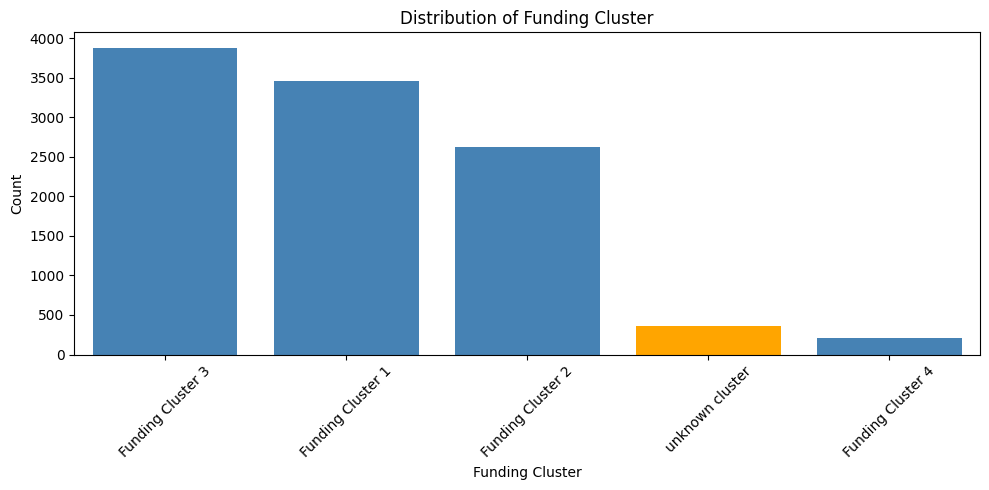

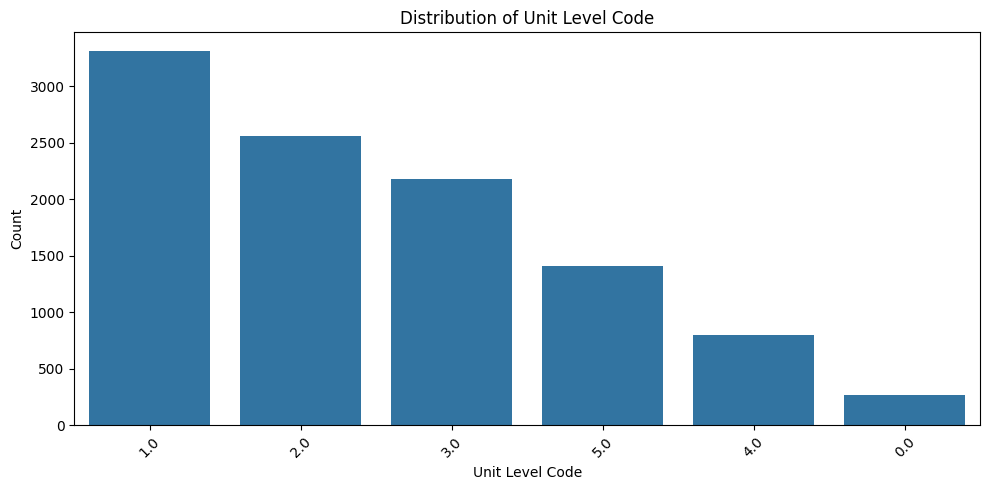

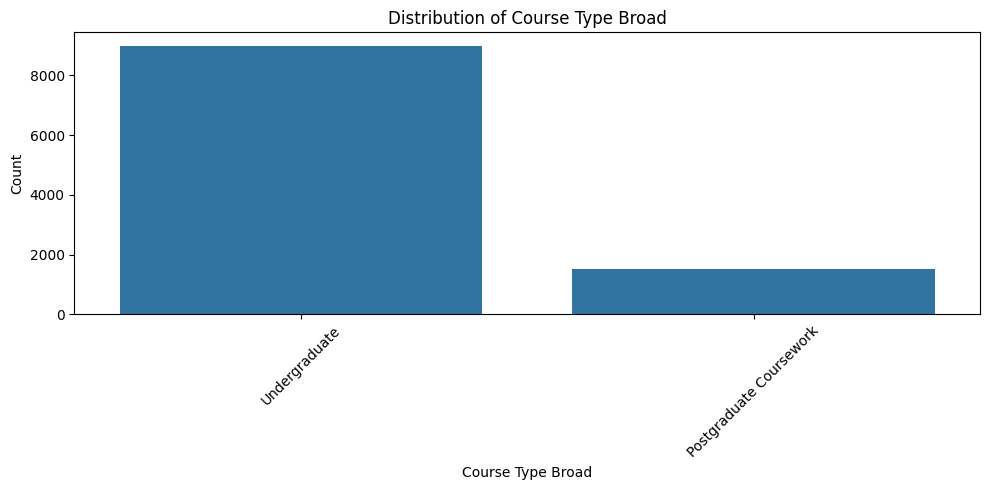

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = ['funding_cluster', 'unit_level_code', 'course_type_broad']

# Ensure funding_cluster is string for replacement consistency
df['funding_cluster'] = df['funding_cluster'].astype(str)
df['funding_cluster'] = df['funding_cluster'].replace('0', 'unknown cluster')

for col in categorical_cols:
    plt.figure(figsize=(10,5))

    # Countplot
    ax = sns.countplot(x=col, data=df, order=df[col].value_counts().index)

    # Highlight specific bars for funding_cluster
    if col == 'funding_cluster':
        for patch, label in zip(ax.patches, df[col].value_counts().index):
            if label in ['3', 'unknown cluster']:
                patch.set_facecolor('orange')
            else:
                patch.set_facecolor('steelblue')

    plt.xticks(rotation=45)
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel("Count")
    plt.title(f"Distribution of {col.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()






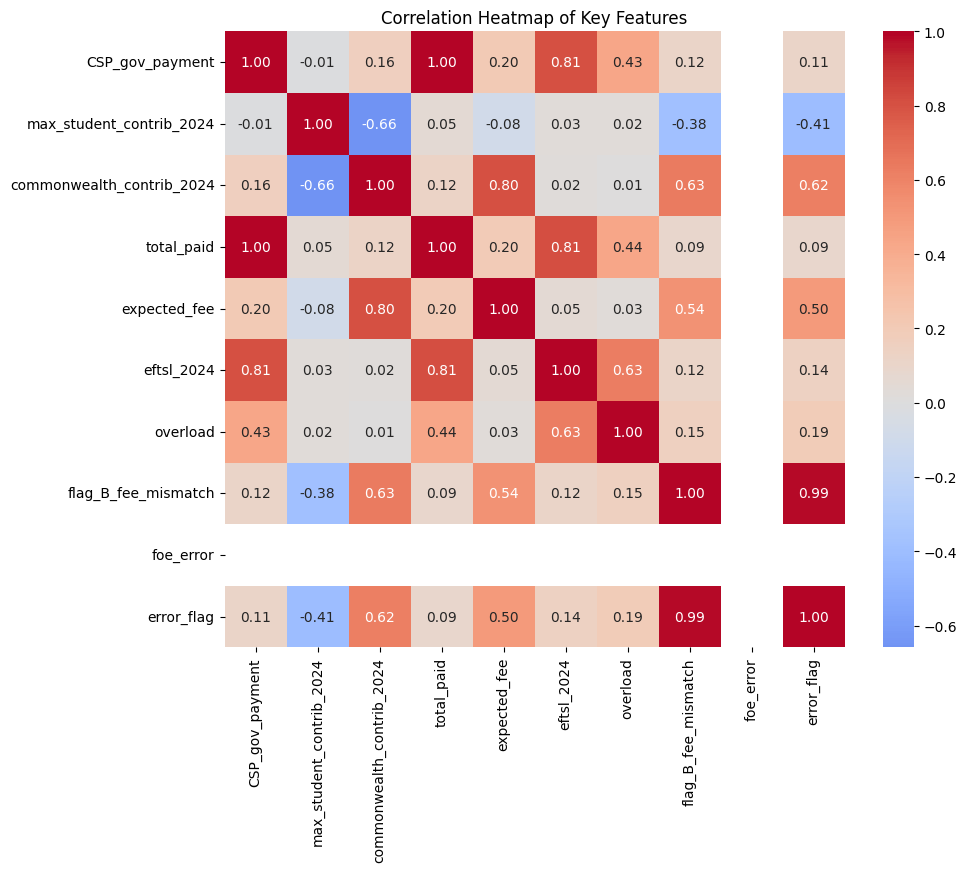

In [46]:
important_features = [
    'CSP_gov_payment',
    'max_student_contrib_2024',
    'commonwealth_contrib_2024',
    'total_paid',
    'expected_fee',
    'eftsl_2024',
    'overload',
    'flag_B_fee_mismatch',
    'foe_error',
    'error_flag'
]

corr_matrix = df[important_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Key Features")
plt.show()



**Strong Positive Correlation**


1.   flag_g_fee_mismatch ↔ error_flag (0.99): These two variables are almost identical. Keeping both in a model may cause redundancy, so usually one is enough.
2.   commonwealth_contrib_2024 ↔ total_paid (0.62): When Commonwealth contributions increase, the total paid amount also increases significantly.


**Strong Negative Correlations**


1.  max_student_contrib_2024 ↔ commonwealth_contrib_2024 (-0.66): If students pay more, Commonwealth pays less, and vice versa. This reflects the funding trade-off.
2.  max_student_contrib_2024 ↔ error_flag (-0.41): Higher student contributions are slightly associated with fewer errors being flagged.




**Moderate Correlations**


1.   expected_fee ↔ eftsl_2024 (0.54): Higher study load (EFTSL) is linked with higher expected fees.
2.   overload ↔ total_paid (0.43): Students who overload subjects tend to pay more








In [49]:
# ------------------------
# 4. Features & One-Hot Encoding
features = ['eftsl_2024', 'funding_cluster', 'unit_level_code', 'course_type_broad']
X = pd.get_dummies(df[features], drop_first=True)
y = df['error_flag']

In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------
# 5. Scaling
scaler = StandardScaler(with_mean=False)  # works with dummy variables
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------
# 6. Logistic Regression
log_reg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

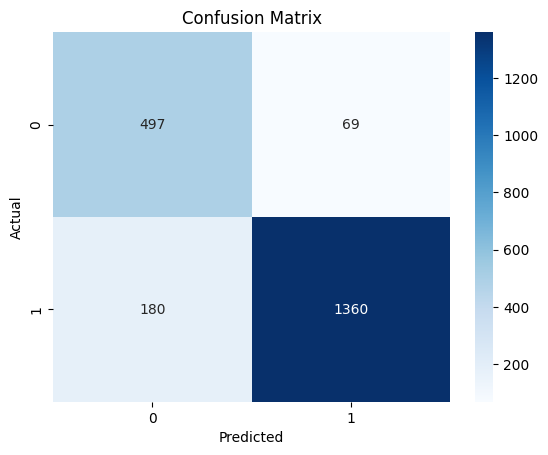

In [53]:
# ------------------------
# 7. Model Evaluation

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix shows how well the model predicted the two classes. The model correctly predicted 497 cases as class 0 and 1360 cases as class 1. It made some mistakes, predicting 69 cases as class 1 when they were actually class 0 (false positives), and 81 cases as class 0 when they were actually class 1 (false negatives). Overall, most predictions were correct, and the model performed well at identifying both classes. The small number of mistakes shows that the model is reliable and gives accurate results.

In [56]:

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.8946107337891791


In [57]:

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80       566
         1.0       0.95      0.88      0.92      1540

    accuracy                           0.88      2106
   macro avg       0.84      0.88      0.86      2106
weighted avg       0.89      0.88      0.88      2106



The classification report shows how well the model performed on the test data. For class 0, the model correctly identified 88% of the actual instances (recall), but only 73% of its predictions for class 0 were correct (precision), resulting in an F1-score of 0.80. For class 1, the model performed better, correctly identifying 88% of instances with 95% of its predictions being correct, giving an F1-score of 0.92. Overall, the model achieved an accuracy of 88%, meaning it correctly classified 88% of all cases. The weighted average F1-score is 0.88, reflecting strong overall performance, with slightly better results for class 1 due to it having more instances in the dataset. This indicates that the model is reliable and performs well across both classes, though it is slightly more precise in predicting class 1.

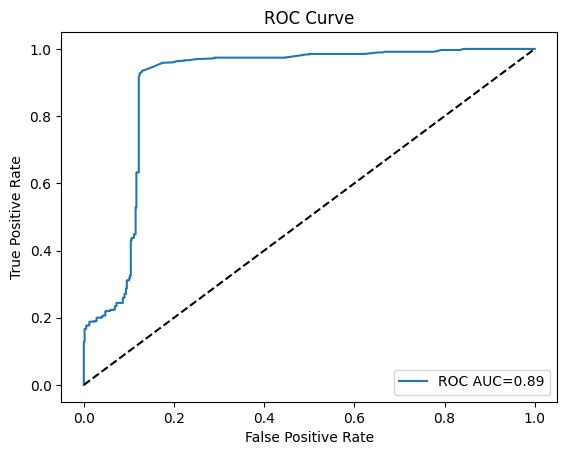

In [59]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

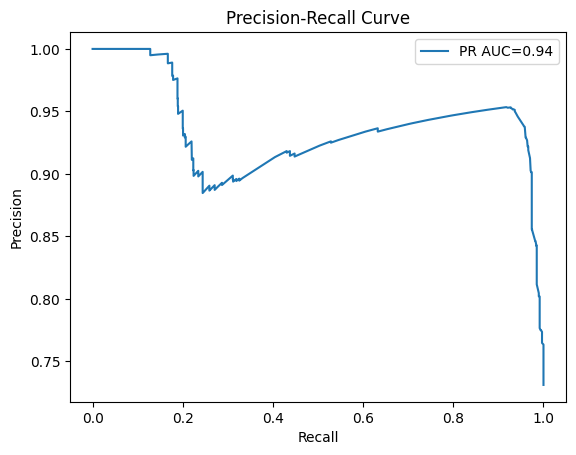

In [60]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

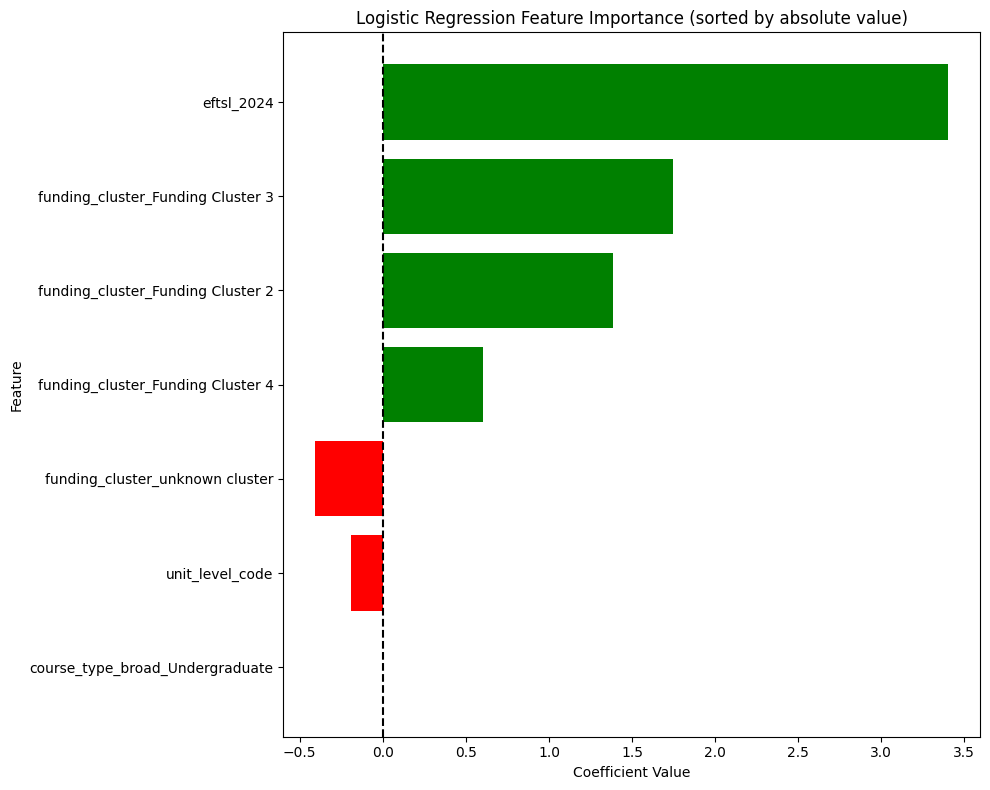

In [65]:

# Get coefficients
coefficients = pd.Series(log_reg.coef_[0], index=X.columns)

# Sort by absolute value
coefficients_sorted = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)

# Colors by sign
colors = ['green' if val > 0 else 'red' for val in coefficients_sorted.values]

# Plot using Matplotlib directly
plt.figure(figsize=(10,8))
plt.barh(coefficients_sorted.index, coefficients_sorted.values, color=colors)
plt.axvline(0, color='k', linestyle='--')
plt.title("Logistic Regression Feature Importance (sorted by absolute value)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()
plt.show()





In [66]:
odds_ratios = np.exp(log_reg.coef_[0])
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0], 'Odds_Ratio': odds_ratios})
coeff_df = coeff_df.sort_values(by='Odds_Ratio', ascending=False)
print(coeff_df)



                             Feature  Coefficient  Odds_Ratio
0                         eftsl_2024     3.403617   30.072671
3  funding_cluster_Funding Cluster 3     1.745647    5.729605
2  funding_cluster_Funding Cluster 2     1.383407    3.988466
4  funding_cluster_Funding Cluster 4     0.600803    1.823582
6    course_type_broad_Undergraduate     0.003812    1.003819
1                    unit_level_code    -0.190037    0.826928
5    funding_cluster_unknown cluster    -0.408297    0.664781


The table shows how different factors influence the likelihood of an error occurring (error_flag) according to the logistic regression model. Each feature has a coefficient and an odds ratio. A positive coefficient increases the chances of an error (error_flag = 1), while a negative coefficient decreases the chances.

From the table, eftsl_2024 has the strongest positive effect, with a coefficient of 3.40 and an odds ratio of about 30, meaning that higher eftsl_2024 values greatly increase the likelihood of an error. Funding clusters 2, 3, and 4 also increase the chance of an error, with cluster 3 having the largest effect among them (odds ratio ≈ 5.73). In contrast, unit_level_code (coefficient = -0.19, odds ratio ≈ 0.83) and the unknown funding cluster (coefficient = -0.41, odds ratio ≈ 0.66) reduce the likelihood of an error. Features like course_type_broad_Undergraduate have almost no effect (odds ratio ≈ 1), indicating they do not meaningfully change the chance of an error.

Overall, the table highlights which factors are most strongly associated with errors: eftsl_2024 and certain funding clusters increase the risk, while a few other features slightly reduce it or have minimal impact.

In [67]:
# 9. Cross-Validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("CV ROC-AUC:", cv_scores.mean())

CV ROC-AUC: 0.888286932232327


Sample Data:
        eftsl_2024    funding_cluster  unit_level_code course_type_broad  \
17598       0.250  Funding Cluster 1              3.0     Undergraduate   
13394      11.500  Funding Cluster 1              3.0     Undergraduate   
11059       0.750  Funding Cluster 1              4.0     Undergraduate   
13545       0.125  Funding Cluster 1              3.0     Undergraduate   
16345       0.125  Funding Cluster 1              1.0     Undergraduate   

       error_flag  
17598         1.0  
13394         1.0  
11059         1.0  
13545         0.0  
16345         0.0  

Predictions for 5 Sample Rows:

       course_id   unit_id  error_flag  predicted_error_flag  predicted_prob
17598     2976.0  234419.0         1.0                   0.0        0.099467
13394     2969.0  234012.0         1.0                   1.0        0.998242
11059     2951.0  192172.0         1.0                   0.0        0.117396
13545     2951.0  236992.0         0.0                   0.0        0.0912

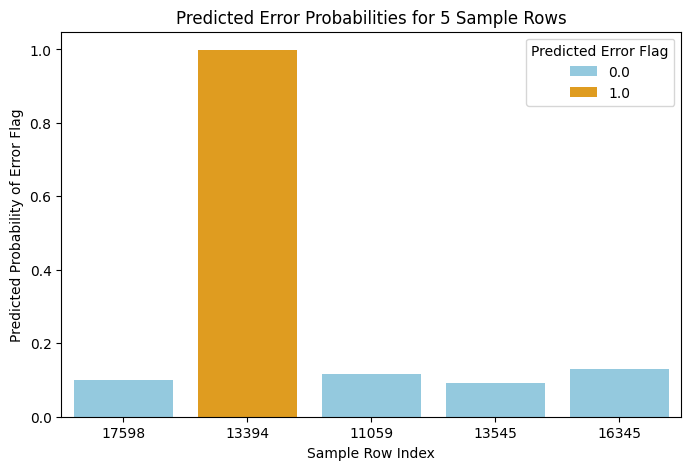

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 1. Select 5 sample rows
sample_data = df.sample(5, random_state=42).copy()
print("Sample Data:\n", sample_data[features + ['error_flag']])

# ------------------------
# 2. Preprocess sample rows
sample_X = pd.get_dummies(sample_data[features], drop_first=True)

# Ensure all columns match training data
missing_cols = set(X.columns) - set(sample_X.columns)
for col in missing_cols:
    sample_X[col] = 0
sample_X = sample_X[X.columns]  # reorder columns to match training data

# Scaling
sample_X_scaled = scaler.transform(sample_X)  # use the fitted scaler from training

# ------------------------
# 3. Make predictions
sample_data['predicted_error_flag'] = log_reg.predict(sample_X_scaled)
sample_data['predicted_prob'] = log_reg.predict_proba(sample_X_scaled)[:,1]

# ------------------------
# 4. Show results
print("\nPredictions for 5 Sample Rows:\n")
print(sample_data[['course_id','unit_id','error_flag','predicted_error_flag','predicted_prob']])

# ------------------------
# 5. Visualization of predicted probabilities
plt.figure(figsize=(8,5))
sns.barplot(
    x=sample_data.index.astype(str),
    y=sample_data['predicted_prob'],
    hue=sample_data['predicted_error_flag'],
    dodge=False,
    palette={0:'skyblue', 1:'orange'}
)
plt.xlabel("Sample Row Index")
plt.ylabel("Predicted Probability of Error Flag")
plt.title("Predicted Error Probabilities for 5 Sample Rows")
plt.legend(title="Predicted Error Flag")
plt.show()


In [68]:
# ------------------------
# 10. Save results for visualization / Power BI
results_df = X_test.copy()
results_df['True_Error'] = y_test.values
results_df['Predicted_Error'] = y_pred
results_df['Predicted_Probability'] = y_prob
results_df.to_csv('logistic_predictions.csv', index=False)